In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

from dataset import TinyShakes

from cosmosis.model import GPT
from cosmosis.dataset import AsTensor
from cosmosis.learning import Learn, Selector, Metrics

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch

In [2]:
ds_param = {'transforms': {'X1': [AsTensor()], # target
                           'X2': [AsTensor()]},
            'block_size': 10}

ts = TinyShakes(**ds_param)

tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyskakes_encoded.bin
len(self.ds_idx):  338015
data.nbytes:  676050
CDataset created...


In [3]:
data = ts[1000]

print(data)
print(data['X1'].shape)
print(type(data['X1']))
print(data['X1'].dtype)

{'X1': tensor([ 198, 1169, 3595,   13, 1002,  262, 9976, 4483,  514,  407]), 'X2': tensor([1169, 3595,   13, 1002,  262, 9976, 4483,  514,  407,  510])}
torch.Size([10])
<class 'torch.Tensor'>
torch.int64


In [4]:
model_param = {'device': 'cpu',
               'd_model': 8, # matches embedding dimension
               'd_vocab': 50304, # matches embedding vocab
               'n_head': 2, 
               'num_layers': 2,
               'linear_head': True,
               'probs': False, # softmax
               'tokens': False, # multinomial
               'transpose': False, 
               'embed_param': {'X1': (50304, 8, None, True),
                               'X2': (50304, 8, None, True)}} 

gpt = GPT(model_param)

CModel loaded...


In [5]:
out = gpt(data)

In [6]:
print(out)
print(out.shape)
print(out.dtype)

tensor([[ 0.6138,  0.6739, -0.5095,  ...,  0.2041,  0.0000, -0.1754],
        [-0.2924,  0.2480,  0.5024,  ..., -0.4601, -0.0000,  0.4064],
        [ 1.2243, -0.6630,  0.6865,  ...,  0.9794,  0.0628,  0.4121],
        ...,
        [ 0.8794, -0.0000, -0.4544,  ...,  1.3360, -0.6383, -0.0000],
        [-0.3470, -0.2362, -0.6718,  ...,  0.0033,  0.0860, -0.9900],
        [ 0.1418,  1.1563, -0.7950,  ..., -0.6467,  0.0000, -0.7438]],
       grad_fn=<MulBackward0>)
torch.Size([10, 50304])
torch.float32


In [7]:
cel_func = CrossEntropyLoss()
prompt_tokens = data['X2']
print('prompt_tokens: ', prompt_tokens, prompt_tokens.shape, prompt_tokens.dtype)

target_tokens = data['X1']
target_tokens.unsqueeze(0)
print('target_tokens: ', target_tokens, target_tokens.shape, target_tokens.dtype)

generated_tokens = out
generated_tokens.unsqueeze(0)
print('generated_tokens: ', generated_tokens.unsqueeze(0), generated_tokens.shape, generated_tokens.dtype)

loss = cel_func(generated_tokens, target_tokens)
print('loss: ', loss)

prompt_tokens:  tensor([1169, 3595,   13, 1002,  262, 9976, 4483,  514,  407,  510]) torch.Size([10]) torch.int64
target_tokens:  tensor([ 198, 1169, 3595,   13, 1002,  262, 9976, 4483,  514,  407]) torch.Size([10]) torch.int64
generated_tokens:  tensor([[[ 0.6138,  0.6739, -0.5095,  ...,  0.2041,  0.0000, -0.1754],
         [-0.2924,  0.2480,  0.5024,  ..., -0.4601, -0.0000,  0.4064],
         [ 1.2243, -0.6630,  0.6865,  ...,  0.9794,  0.0628,  0.4121],
         ...,
         [ 0.8794, -0.0000, -0.4544,  ...,  1.3360, -0.6383, -0.0000],
         [-0.3470, -0.2362, -0.6718,  ...,  0.0033,  0.0860, -0.9900],
         [ 0.1418,  1.1563, -0.7950,  ..., -0.6467,  0.0000, -0.7438]]],
       grad_fn=<UnsqueezeBackward0>) torch.Size([10, 50304]) torch.float32
loss:  tensor(11.0196, grad_fn=<NllLossBackward0>)


tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyskakes_encoded.bin
len(self.ds_idx):  1000
data.nbytes:  676050
CDataset created...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:09.593797
epoch: 0, lr: 0.01
train loss: 0.3205190410559205, val loss: 0.2446113195684221
last targets: 
[27075, 11, 4249, 3656, 30, 198, 198, 43, 9598, 9399, 25, 198, 3666, 15876, 11, 673, 743, 307, 257, 22782, 26, 329, 867, 286, 606, 389, 198, 710, 1555, 25920, 11, 27075, 11, 4249, 3656, 13, 198, 198, 35, 52, 7336, 569, 30158, 3525, 9399, 25, 198, 15086, 594, 326]
last predictions: 
[284, 11, 198, 616, 198, 198, 198, 314, 11, 13, 25, 198, 616, 11, 11, 314, 25, 307, 257, 290, 11, 314, 314, 11, 11, 616, 198, 25, 11, 314, 11, 25, 11, 198, 198, 11, 198, 198, 314, 26, 198, 13, 198, 13, 13, 25, 198, 25, 25, 290]
test loss: 0.18789394365416634

...........................
learning time: 0:00:19.020872
last targets: 
[35, 724, 11, 55

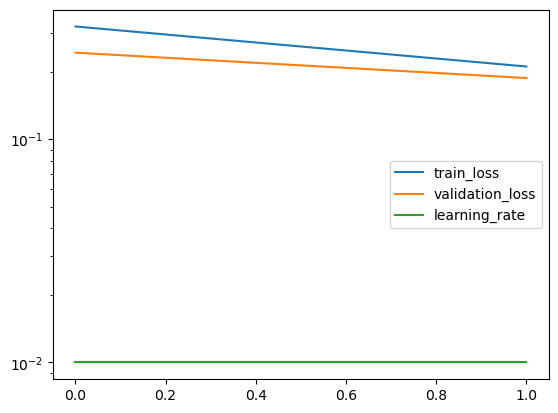

In [2]:

ds_param = {'train_param': {'transforms': {'X1': [AsTensor()],
                                           'X2': [AsTensor()]},
                            'block_size': 50,
                            'n': 1000}}

model_param = {'device': 'cuda',
               'd_model': 32, # matches embedding dimension
               'd_vocab': 50304, # matches embedding vocab
               'n_head': 4, 
               'num_layers': 3,
               'linear_head': True,
               'probs': False,
               'tokens': False,
               'transpose': True, 
               'embed_param': {'X1': (50304, 32, None, True),
                               'X2': (50304, 32, None, True)}} 
                                       
metrics_param = {'metric_name': 'transformer',
                 'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .005} # break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=24, epochs=2, gpu=True, squeeze_y_pred=True, target='X1')